# **Métodos Avanzados en Aprendizaje Automático**

## Algoritmo de Eliminación de Variables y Gradient Boosting

*Autores: Mercedes García Villaescusa y Daniel Beteta Francisco*

# **Parte 1: Variable Elimination Algorithm**

## **Librerías utilizadas**

## Algoritmo de Eliminación de Variables

Este algoritmo es para hacer inferencia en redes. Supongamos que tenemos la factorización de una distribución conjunta 

$$ P(\mathbf{X}) = P(X_1, X_2, \dots, X_N) = \prod_{i=1}^N P(X_i|Par(X_i))$$ 

y una evidenica $ \mathbf{Z}=\mathbf{z} $, donde $\mathbf{Z} \subset \mathbf{X}$ es un subconjunto de las variables del problema y $\mathbf{z}$ son sus valores observados. El objetivo es obtener la distribución de parte de las variables del problema, $\mathbf{W} \subset \mathbf{X}$ dada la evidencia $\mathbf{Z}=\mathbf{z}$. Es decir queremos obtener $P(\mathbf{W}|\mathbf{Z}=\mathbf{z})$. Para ello debemos:
* Reducir los factores que incluyan $\mathbf{Z}$
* Eliminar el resto de variables no incluidas $\mathbf{W}$

$$ P(\mathbf{W}|\mathbf{Z}=\mathbf{z}) = \sum_{X \setminus (W\cup Z)} \frac{P(\mathbf{X}\setminus \mathbf{Z},\mathbf{Z}=\mathbf{z})}{P(\mathbf{Z}=\mathbf{z})} \propto \sum_{X \setminus (W\cup Z)} P(\mathbf{X}\setminus \mathbf{Z},\mathbf{Z}=\mathbf{z}) $$


Algoritmo de eliminación de variables esquemático para un conjunto de factores $\mathbf{\Phi}=\{\Phi_1,\dots,\Phi_N\}$:
1.  Reducir todos los factores que contengan alguna variable de $\mathbf{Z}$ en su dominio, usando la evidencia dada $\mathbf{Z}=\mathbf{z}$
2.  Para cada varible X no en $\mathbf{X} \setminus (\mathbf{W} \cup \mathbf{Z})$, eliminar variable X mediante marginalización:
    1. Hacer el producto de todos los factores que tienen X es su dominio: $\psi = \prod_{\Phi_i \mid X\in Dom(\Phi_i) }\Phi_i$ 
    2. Marginalizar X del factor producto obtenido en A: $\tau = \sum_X \psi$
    3. Actualizar la lista de factores quitando los factores que incluyen X y añadiendo el factor marginalizado $\tau$: $\mathbf{\Phi} = (\mathbf{\Phi} \setminus {\psi}) \cup \tau$
3. Multiplicar factores restantes
4. Renormalizar para obtener una distribución

## **Librerías utilizadas**

In [1]:
import numpy as np
import math

## **Funciones auxiliares**

Primero definimos las probabilidades que nos dan en el enunciado, así como su dimensión y nombre de la variable.

In [2]:
PI = np.array([0.7, 0.3]).reshape((2,1,1,1,1))
PD = np.array([0.6, 0.4]).reshape((1,2,1,1,1))
PG_ID = np.array([0.3, 0.4, 0.3, 0.05, 0.25, 0.7, 0.9, 0.08, 0.02, 0.5, 0.3, 0.2]).reshape((2,2,3,1,1))
PL_G = np.array([0.1, 0.9, 0.4, 0.6, 0.99, 0.01]).reshape((1,1,3,2,1))
PS_I = np.array([0.95, 0.05, 0.2, 0.8]).reshape((2,1,1,1,2))

También nos será útil definir diversas operaciones que nos servirá para normalizar, reducir y calcular la marginal. 

In [3]:
def normalize(distribution):
    return distribution/np.sum(distribution)

def reduce(distribution, variables, asignments, normalize_output=True):
    """ This function receives a distribution, 
        a list of indices to variables and 
        a list of the assignements to those variables """
    
    reduced = distribution.copy()
    
    for variable, asignment in zip(variables,asignments):
        reduced = np.swapaxes(reduced, 0, variable)[[asignment]]
        reduced = np.swapaxes(reduced, 0, variable)
        
    return normalize(reduced) if normalize_output else reduced

def marginal(distribution, variables):
    """ Marginalizes the distributions for the given list of variables """
    
    return np.sum(distribution, axis=tuple(variables), keepdims=True)

## **Implementación de Variable Elimination Algorithm**

In [4]:
def VA(factor_list, W, Zs=[], zs=[], order=[]):
    """ Implementar variable elimination algorithm
    
        Entrada:
           * factor_list: lista con los factores a procesar
           * W:           lista de variables en el factor de salida
           * Zs:          lista de variables observadas
           * zs:          lista de valores de las variables observadas
           * order:       orden en que se procesan las variables. Si no se 
                          indica nada se hacer en orden ascendente
        Salida:
           * Factor con la distribucion conjunta W dada la evidencia
           * El tamaño del factor más grande que se procese
        
    """

    # Primero determinamos la lista de factores 
    factor_list = np.array(factor_list, dtype = object)
    n = factor_list.shape[0]

    # Si se ha indicado un orden, se procesan las variables en dicho orden
    if order != []:
        order += list(set(range(n)) - set(order))
        factor_list = factor_list[order]
    
    # Para las variables observadas, se reducen los factores
    for (Z, z) in zip(Zs, zs):
        factor_list = [reduce(factor, [Z], [z]) if factor.shape[Z] > 1 else factor for factor in factor_list]
        
    # Marginalizamos los factores que ni han sido observados,
    # ni los queremos en la distribución conjunta de salida
    Xs = set(range(n)) - set(W + Zs)
    
    # Marginalizar producto
    maxsize = 0 #Inicialización para ver cual es el mayor nº de entradas
    for X in Xs:
        X_psi = [factor for factor in factor_list if factor.shape[X] > 1]
        psi = math.prod(X_psi) #Multiplicamos todos los factores de la distribución que dependen del factor (variable) que estamos marginalizando 
        maxsize = max(maxsize, np.prod(psi.shape)) #Comprobamos cual es el mayor nº de entradas
        tau = marginal(psi, [X]) #Marginalizamos
        factor_list = [factor for factor in factor_list if factor.shape[X] == 1] #Mantenemos sólo aquellas que no dependan de la variable ya marginalizada
        factor_list.append(tau) #Añadimos el nuevo factor que hemos obtenido al marginalizar
        
    # Multiplicamos los factores restantes y normalizamos 
    return normalize(math.prod(factor_list)), maxsize
    

## **Comprobación**

Para facilitar la notación y evitar confusiones definimos la relación del nombre de la variable y la dimensión.

In [5]:
I = 0
D = 1
G = 2
L = 3
S = 4

Antes de comenzar la comprobación, recordamos cuales son los valores que pueden tomar los diversos factores

* Nota examen (G): g0 (sobresaliente), g1 (notable), g2 (aprobado)
* Dificultad examen (D): d0 (fácil) y d1 (difícil)
* Inteligencia (I): i0 (normal), i1 (alta)
* Nota Selectividad (S): s0 (baja), s1 (alta)
* Carta de recomendación (L): l0 (regular), l1 (buena)

**Calcula la distribución P(I)**

In [6]:
factor, maxsize = VA([PI, PD, PG_ID, PL_G, PS_I],[I])
print("La distribución P(I) será", factor)
print("El maxsize será",maxsize)

#Comprobamos si se corresponde a lo calculado manualmente en clase
assert(np.allclose(np.array([[[[[0.7]]]],[[[[0.3]]]]]),factor))
assert(maxsize==12)
#Como no ocurren errores vemos que coincide.

La distribución P(I) será [[[[[0.7]]]]



 [[[[0.3]]]]]
El maxsize será 12


Si sabemos que la nota del examen es aprobado, **¿Cuál es la prob de inteligencia? P(I|G=g2)**

In [7]:
factor, maxsize = VA([PI, PD, PG_ID, PL_G, PS_I],[I],[G],[2])
print("La distribución P(I|G=g2) será", factor)
print("El maxsize será",maxsize)

#Comprobamos los resultados.
assert(np.allclose(np.array([[[[[0.92105263]]]],[[[[0.07894737]]]]]), factor))
assert(maxsize==4)

La distribución P(I|G=g2) será [[[[[0.92105263]]]]



 [[[[0.07894737]]]]]
El maxsize será 4


y si además el examen es difícil, **P(I|G=g2,D=d1)**


In [8]:
factor, maxsize = VA([PI, PD, PG_ID, PL_G, PS_I],[0],[D,G],[1,2])
print("La distribución P(I|G=g2, D=d1) será", factor)
print("El maxsize será",maxsize)

#Comprobamos los resultados.
assert(np.allclose(np.array([[[[[0.89090909]]]],[[[[0.10909091]]]]]), factor))
assert(maxsize==4)

La distribución P(I|G=g2, D=d1) será [[[[[0.89090909]]]]



 [[[[0.10909091]]]]]
El maxsize será 4


Prob examen: **Calcula la distribución: P(D)**

In [9]:
factor, maxsize = VA([PI, PD, PG_ID, PL_G, PS_I],[D])
print("La distribución P(D) será", factor)
print("El maxsize será",maxsize)

#Comprobamos los resultados.
assert(np.allclose(np.array([[[[[0.6]]],[[[0.4]]]]]),factor))
assert(maxsize==24)

La distribución P(D) será [[[[[0.6]]]


  [[[0.4]]]]]
El maxsize será 24


Prob examen | **nota aprobado: P(D|G=g2)**

In [10]:
factor, maxsize = VA([PI, PD, PG_ID, PL_G, PS_I],[D],[G],[2])
print("La distribución P(D|G=g2) será", factor)
print("El maxsize será",maxsize)

#Comprobamos los resultados.
assert(np.allclose(np.array([[[[[0.37070938]]],[[[0.62929062]]]]]),factor))
assert(maxsize==8)

La distribución P(D|G=g2) será [[[[[0.37070938]]]


  [[[0.62929062]]]]]
El maxsize será 8


**Probabilidad de examen difícil D=d1|G=g2,S=s1?**

In [11]:
factor, maxsize = VA([PI, PD, PG_ID, PL_G, PS_I],[D],[G,S],[2,1])
print("La distribución P(D=d1|G=g2,S=s1) será", factor)
print("El maxsize será",maxsize)

#Comprobamos los resultados.
assert(np.allclose(np.array([[[[[0.24044002]]],[[[0.75955998]]]]]),factor))
assert(maxsize==4)

La distribución P(D=d1|G=g2,S=s1) será [[[[[0.24044002]]]


  [[[0.75955998]]]]]
El maxsize será 4


Por tanto, la probabilidad de que D=d1, es decir, sea difícil es 0.75955998

**Si no se conoce G, ¿Influye la nota de selectividad en la dificultad del examen?**

In [12]:
print(VA([PI, PD, PG_ID, PL_G, PS_I],[D]))
#Sin saber S

(array([[[[[0.6]]],


        [[[0.4]]]]]), 24)


In [13]:
print(VA([PI, PD, PG_ID, PL_G, PS_I],[D],[S],[1])) 
#Sabiendo S


(array([[[[[0.6]]],


        [[[0.4]]]]]), 12)


Vemos que si no sabemos G, la nota de la selectividad no influye en la dificultad del examen. No existe flujo de información entre D y S, y esto se debe a que existe una estructura en V en el camino.

Si ahora **sabemos que la nota es aprobado**

In [14]:
print(VA([PI, PD, PG_ID, PL_G, PS_I],[D],[G],[2]))

(array([[[[[0.37070938]]],


        [[[0.62929062]]]]]), 8)


Si sabemos que la nota es aprobado, (que es la nota mínima), la probabilidad de la dificultad previa a conocer la nota de la selectividad ha cambiado respecto a la que teníamos anteriormente.

In [15]:
print(VA([PI, PD, PG_ID, PL_G, PS_I],[D],[G,S],[2,1]))

(array([[[[[0.24044002]]],


        [[[0.75955998]]]]]), 4)


En este caso sí que han cambiado las probabilidades al conocer la nota de la selectividad. Saber la nota de la selectividad no nos da información sobre un examen desvinculado, sin embaro, si sabemos la nota de la selectividad y la nota de otro examen, sí que podemos decir que existe un flujo de información.

Tenemos un camino activo, ya que D -> G <- I -> S, tiene una única estructura en V, de la cual conocemos su vértice (V), y el resto de nodos del camino no han sido observados.

# **Parte 2: Gradient Boosting**

## **Librerías utilizadas**

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tabulate import tabulate
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

np.random.seed(123)

## **Funciones auxiliares**

In [17]:
def createDataSet(n, model, ymargin, noise=None, output_boundary=False):
    x = np.random.rand(n,1)*2.0*np.pi
    xbnd = np.linspace(0,2.0*np.pi,100)

    if model == 'sine':
        y = (np.random.rand(n,1) - 0.5)*2.2
        c = y > np.sin(x)
        ybnd = np.sin(xbnd)
    elif model == 'linear':
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    elif model == 'square':
        y = np.random.rand(n,1)*4.0*np.pi*np.pi
        c = y > x*x
        ybnd = xbnd*xbnd
    else:
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    
    y[c == True] = y[c == True] + ymargin
    y[c == False] = y[c == False] - ymargin
    
    if noise is not None:
        y = y + noise * np.random.randn(n,1)
        x = x + noise * np.random.randn(n,1)

    if output_boundary == True:
        return x, y, (c*1).ravel(), xbnd, ybnd
    else:
        return x, y, (c*1).ravel()


def plotData(x, y, c, style0, style1, title=''):
    plt.scatter(x[c==0],y[c==0],**style0)
    plt.scatter(x[c==1],y[c==1],**style1)
    plt.grid(True)
    plt.axis([x.min()-0.2, x.max()+0.2, y.min()-0.2, y.max()+0.2])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

## **Implementación**

Solo se va a implementar para regresión y para clasificación binaria con clases igual a -1 y +1


In [18]:
class SquaredErrorLoss:
    """ Clase que define elementos para la función cuadrática de perdida 
        para regresión """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la salida 'y' """

        return np.mean(y)

    def residuos(_, y, F):
        """ Calcula los residuos para un objetivo 'y' y 
            una salida del modelo F """

        return y - F

    def paso_newton_hoja(_, y, residuos, valor):
        """ Función para actualizar la salida de una hoja el árbol
        
           Recibe información sobre los ejemplos de una hoja dada. En concreto
           para los ejemplos que caen en una hoja:
              * El vector de valores a predecir (y)
              * Los pseudo-residuos (residuos) sobre los que se ha
                entrenado alarbol regresor ht
           Además recine el valor actual de salida de la hoja
              
            Debe devolver el valor actualizado
        """

        return valor 
    
    def predict(_, y):
        return y

    def __call__(self, y, F):
        """ Devuelve el valor de la función de pérdida para un objetivo 'y' y 
            una salida del modelo F """

        return 0.5*(y-F)**2
    
class LogLoss:
    """ Clase que define elementos para la función logística de perdida 
        para clasificación de dos clases {-1, +1} """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la salida 'y' """

        y_mean = np.mean(y)
        return 0.5 * np.log((1.0+y_mean) / (1.0-y_mean))

    def residuos(_, y, F):
        """ Calcula los residuos para un objetivo 'y' y 
            una salida del modelo F """

        return (2.0 * y) / (1 + np.exp(2.0*y*F))

    def paso_newton_hoja(_, y, residuos, valor):
        """ Función para actualizar la salida de una hoja el árbol
        
           Recibe información sobre los ejemplos de una hoja dada. En concreto
           para los ejemplos que caen en una hoja:
              * El vector de valores a predecir (y)
              * Los pseudo-residuos (residuos) sobre los que se ha
                entrenado alarbol regresor ht
           Además recine el valor actual de salida de la hoja
              
            Debe devolver el valor actualizado
        """

        absolute_values_residuals = np.abs(residuos)
        
        numerator = np.sum(residuos)
        denominator = np.sum(
            absolute_values_residuals * (2.0 - absolute_values_residuals)
        )
        
        if np.abs(denominator) < 1e-15:
            return 0.0

        return numerator / denominator
    
    def predict(_, y):
        return 2*((1.0/(1.0 + np.exp(-2 * y))) >= 0.5) - 1

    def __call__(self,y, F):
        """ Devuelve el valor de la función de pérdida para un objetivo 'y' y 
            una salida del modelo F """

        return np.log(1+np.exp(-2.0*y*F))
     
class GBCasero:
    def __init__(self, n_estimators=101, loss=SquaredErrorLoss(), eta=0.1, depth=3):
        self.n_estimators = n_estimators
        self._estimators  = []
        self.depth        = depth
        self.eta          = eta
        self.loss         = loss
    
    def fit(self,X,y):
        """
          Inicializa GB 
        """

        for _ in range(self.n_estimators):
            tree = DecisionTreeRegressor(max_depth=self.depth)
            """
              Rellenar esta parte para implementar GB 
              Se debe utilizar la función paso_newton de abajo
            """
            residuos = self.loss.residuos(y, self.predict(X))
            tree = tree.fit(X, residuos)
            self.paso_newton_general(tree, X, y, residuos)
            self._estimators.append(tree)
            
    def predict(self,X):
        """ Combinamos los valores de pesos y hs para obtener la 'salida' o
             predicciones en crudo, y que haga:
               * Para regresión se devuelve 'salida'
               * Para clasificación de 2 clases se calcula la probabilidad
                  con una sigmoidal (1 / (1 + np.exp(-2*salida))) y se 
                  devuelve la clase más probable 
                  
            Nota1: Podéis delegar esto a las funciones de pérdida para evitar 
                   poner aquí in if
            Nota2: Podéis también organizar la clasificacion/regresion al estilo
                   sklearn e implementar predict_proba en la clasificación.
                
        """
        
        output = sum(estimator.predict(X)*self.eta for estimator in self._estimators)
        return self.loss.predict(output)   
        
    def paso_newton_general(self, tree, X, y, residuos):
        """ Esta función actualiza todas las hojas de salida
            del árbol 'tree' utilizado la función paso_newton_hoja
            de las clases de funcion de pérdida """
            
        TREE_LEAF = -1
        tree = tree.tree_
        leaf_indices = tree.apply(np.array(X,dtype=np.float32))
        for leaf in np.where(tree.children_left == TREE_LEAF)[0]:
            ii = leaf_indices==leaf
            tree.value[leaf,0,0] = self.loss.paso_newton_hoja(y[ii],
                                                              residuos[ii],
                                                              tree.value[leaf,0,0])

## **Análisis de nuestra implementación**

### Preparación de los datos

In [19]:
dict_prepared_data = dict()

#### Creación de los datos: *Sine*

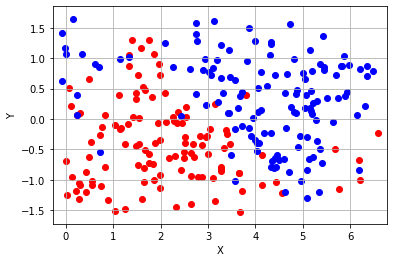

In [20]:
x_train, y_train, c_train = createDataSet(
    n=250, model="sine", ymargin=0.0, noise=0.3, output_boundary=False
)

plotData(x_train, y_train, c_train, {'c':'#FF0000'}, {'c':'#0000FF'})

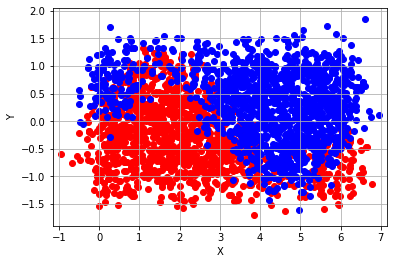

In [21]:
x_test, y_test, c_test  = createDataSet(
    n=2500, model="sine", ymargin=0.0, noise=0.3, output_boundary=False 
)

plotData(x_test, y_test, c_test, {'c':'#FF0000'}, {'c':'#0000FF'})

In [22]:
training_data = np.concatenate((x_train, y_train), axis=1)
test_data = np.concatenate((x_test, y_test), axis=1)

lb = LabelBinarizer(pos_label=1, neg_label=-1)
train_labels = lb.fit_transform(c_train).ravel()
test_labels = lb.transform(c_test).ravel()

dict_prepared_data["created_sine_data"] = [
    training_data, train_labels, test_data, test_labels
]

#### Carga de los datasets: *magic04, pimaND, sonar y spamND*

In [23]:
list_datasets = ['magic04.csv', 'pimaND.csv', 'sonar.csv', 'spamND.csv']

for dataset in list_datasets:
  df = pd.read_csv(dataset, sep=',').dropna()
  training_data, test_data, c_train, c_test = train_test_split(
      df.values[:,:-1], df.values[:,-1], 
      test_size=0.8, random_state=1
  )
  lb = LabelBinarizer(pos_label=1, neg_label=-1)
  train_labels = lb.fit_transform(c_train).ravel()
  test_labels = lb.transform(c_test).ravel()

  dict_prepared_data[dataset] = [
      training_data, train_labels, test_data, test_labels
  ]

### Gradient Boosting para clasificación

In [24]:
gb_clf_scores = list()

for dataset, data in dict_prepared_data.items():
  training_data, train_labels, test_data, test_labels = data

  my_gb_clf = GBCasero(loss=LogLoss())
  my_gb_clf.fit(training_data, train_labels)
  my_prediction_values = my_gb_clf.predict(test_data)
  my_score = np.sum(my_prediction_values==test_labels) / len(test_labels)

  sk_gb_clf = GradientBoostingClassifier(n_estimators=101, learning_rate=0.1, max_depth=3)  
  sk_gb_clf.fit(training_data, train_labels)
  sk_prediction_values = sk_gb_clf.predict(test_data)
  sk_score = np.sum(sk_prediction_values==test_labels) / len(test_labels)

  gb_clf_scores.append([dataset.replace(".csv", ""), my_score, sk_score])

print(tabulate(gb_clf_scores, headers=["Accuracy (Our implementation)", "Accuracy (Sklearn implementation)"], tablefmt='fancy_grid'))

╒═══════════════════╤═════════════════════════════════╤═════════════════════════════════════╕
│                   │   Accuracy (Our implementation) │   Accuracy (Sklearn implementation) │
╞═══════════════════╪═════════════════════════════════╪═════════════════════════════════════╡
│ created_sine_data │                        0.834    │                            0.8488   │
├───────────────────┼─────────────────────────────────┼─────────────────────────────────────┤
│ magic04           │                        0.850881 │                            0.86225  │
├───────────────────┼─────────────────────────────────┼─────────────────────────────────────┤
│ pimaND            │                        0.739837 │                            0.731707 │
├───────────────────┼─────────────────────────────────┼─────────────────────────────────────┤
│ sonar             │                        0.610778 │                            0.610778 │
├───────────────────┼─────────────────────────────────┼─────

### Gradient boosting para regresión

In [25]:
gb_reg_scores = list()

for dataset, data in dict_prepared_data.items():
  training_data, train_labels, test_data, test_labels = data

  my_gb_reg = GBCasero(loss=SquaredErrorLoss())
  my_gb_reg.fit(training_data, train_labels)
  my_prediction_values = my_gb_reg.predict(test_data)
  my_score = r2_score(test_labels, my_prediction_values)
  
  sk_gb_reg = GradientBoostingRegressor(loss="squared_error", n_estimators=101, learning_rate=0.1, max_depth=3)
  sk_gb_reg.fit(training_data, train_labels)
  sk_score = sk_gb_reg.score(test_data, test_labels)

  gb_reg_scores.append([dataset.replace(".csv", ""), my_score, sk_score])

print(tabulate(gb_reg_scores, headers=["R^2 (Our implementation)", "R^2 (Sklearn implementation)"], tablefmt='fancy_grid'))

╒═══════════════════╤════════════════════════════╤════════════════════════════════╕
│                   │   R^2 (Our implementation) │   R^2 (Sklearn implementation) │
╞═══════════════════╪════════════════════════════╪════════════════════════════════╡
│ created_sine_data │                  0.551599  │                      0.551265  │
├───────────────────┼────────────────────────────┼────────────────────────────────┤
│ magic04           │                  0.536367  │                      0.53639   │
├───────────────────┼────────────────────────────┼────────────────────────────────┤
│ pimaND            │                  0.130274  │                      0.123006  │
├───────────────────┼────────────────────────────┼────────────────────────────────┤
│ sonar             │                 -0.521554  │                     -0.513938  │
├───────────────────┼────────────────────────────┼────────────────────────────────┤
│ spamND            │                 -0.0725092 │                     -0.07

En conclusión, nuestra implementación es competitiva frente a la de Sklearn, arrojando resultados muy similares tanto en clasificación como en regresión.